In [7]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test,init_detector,inference_detector,show_result_pyplot
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

# from ensemble_boxes import *

In [12]:
classes = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
# config file 들고오기

config_file_name = 'cascade_mask_rcnn_swin_small_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco'
cfg = Config.fromfile('./configs/swin/cascade_mask_rcnn_swin_small_patch4_window7_mstrain_480-800_giou_4conv1f_adamw_3x_coco.py')

PREFIX = '../../input/data/'

epoch = 16

# dataset 바꾸기
cfg.data.train.classes = classes
cfg.data.train.img_prefix = PREFIX
cfg.data.train.ann_file = PREFIX + 'train_all.json'
# cfg.data.train.pipeline[2]['img_scale'] = (512, 512)

cfg.data.val.classes = classes
cfg.data.val.img_prefix = PREFIX
cfg.data.val.ann_file = PREFIX + 'val.json'
# cfg.data.val.pipeline[1]['img_scale'] = (512, 512)

cfg.data.test.classes = classes
cfg.data.test.img_prefix = PREFIX
cfg.data.test.ann_file = PREFIX + 'test.json'
# cfg.data.test.pipeline[1]['img_scale'] = (512, 512)

cfg.data.samples_per_gpu = 1

cfg.seed=2020
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs'

# cfg.model.roi_head.bbox_head.num_classes = 11

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}(best_trainall).pth')

In [13]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [49]:
cfg.model.test_cfg.rpn.nms = dict(type='nms', iou_threshold=0.8)
cfg.model.test_cfg.rcnn.nms = dict(type='nms', iou_threshold=0.8)

Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: neck.downsample_convs.0.conv.weight, neck.downsample_convs.0.conv.bias, neck.downsample_convs.1.conv.weight, neck.downsample_convs.1.conv.bias, neck.downsample_convs.2.conv.weight, neck.downsample_convs.2.conv.bias, neck.pafpn_convs.0.conv.weight, neck.pafpn_convs.0.conv.bias, neck.pafpn_convs.1.conv.weight, neck.pafpn_convs.1.conv.bias, neck.pafpn_convs.2.conv.weight, neck.pafpn_convs.2.conv.bias



/opt/ml/code/mmdetection_trash/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/opt/ml/code/mmdetection_trash/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


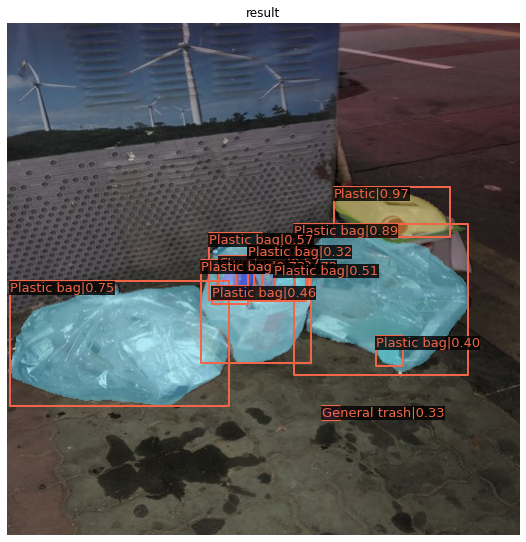

In [4]:
model = init_detector(cfg,checkpoint_path,device='cuda:0')
model.CLASSES = classes
img = '/opt/ml/input/data/batch_01_vt/0108.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [14]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

2021-05-19 19:43:11,019 - mmdet - INFO - load model from: /opt/ml/code/mmdetection_trash/work_dirs/swin/swin_small_patch4_window7_224.pth
2021-05-19 19:43:12,078 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.weight, norm.bias, head.weight, head.bias, layers.0.blocks.1.attn_mask, layers.1.blocks.1.attn_mask, layers.2.blocks.1.attn_mask, layers.2.blocks.3.attn_mask, layers.2.blocks.5.attn_mask, layers.2.blocks.7.attn_mask, layers.2.blocks.9.attn_mask, layers.2.blocks.11.attn_mask, layers.2.blocks.13.attn_mask, layers.2.blocks.15.attn_mask, layers.2.blocks.17.attn_mask

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias



Use load_from_local loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: neck.downsample_convs.0.conv.weight, neck.downsample_convs.0.conv.bias, neck.downsample_convs.1.conv.weight, neck.downsample_convs.1.conv.bias, neck.downsample_convs.2.conv.weight, neck.downsample_convs.2.conv.bias, neck.pafpn_convs.0.conv.weight, neck.pafpn_convs.0.conv.bias, neck.pafpn_convs.1.conv.weight, neck.pafpn_convs.1.conv.bias, neck.pafpn_convs.2.conv.weight, neck.pafpn_convs.2.conv.bias



In [15]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 2.1 task/s, elapsed: 397s, ETA:     0s

In [16]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 11
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    out = out[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,8 0.9915571 175.82036 235.13458 460.6532 473.6...,batch_01_vt/0021.jpg
1,1 0.19965474 2.6511383 247.82626 304.2575 458....,batch_01_vt/0028.jpg
2,1 0.5540865 69.669464 168.11871 371.5193 378.5...,batch_01_vt/0031.jpg
3,1 0.06334658 365.41068 215.79716 381.24533 259...,batch_01_vt/0032.jpg
4,1 0.8194016 388.8956 270.9952 506.56058 344.82...,batch_01_vt/0070.jpg
